In [27]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import math
import random

plt.rc('font', family='Malgun Gothic')
random.seed(2022)

# 1단계)   ERROR 열에서 평균 / 표준편차를 구한다.
error_df = pd.read_excel("data/실제실험데이터_Error.xlsx", header=1) 

gaussian_mean = {}
gaussian_std = {}

for i in [80,90,100,110,120]: 
    gaussian_mean[i] = error_df['ERROR_'+ str(i)].mean() #평균
    gaussian_std[i] = error_df['ERROR_'+ str(i)].std() #표준편차

# 2단계)   'graph2_논문자체 회귀데이터'에 추가하여 데이터를 생성한다
regression_data = pd.read_excel("data/논문자체 회귀데이터.xlsx", header=1) 

data_80 =  regression_data[['Time_80','Y_80']][:64]
data_90 =  regression_data[['Time_90','Y_90']][:57]
data_100 =  regression_data[['Time_100','Y_100']][:75]
data_110 =  regression_data[['Time_110','Y_110']][:89]
data_120 =  regression_data[['Time_120','Y_120']][:59]

data = data_110
X = 'Time_110'
Y = 'Y_110'

def up_sampling(data):
    df = data
    n=3 #증대 배율
    length = len(data)
    for i in range(n-1):
        l = list(range(length))
        
        df = df.append(df.loc[l], ignore_index = True)
        
        for j in range((i+1)*length,(i+2)*length):
            error = random.gauss(gaussian_mean[int(X.strip("Time_"))], gaussian_std[int(X.strip("Time_"))]) #가우시안 분포를 이용한 오차 랜덤 샘플링
            df[Y][j] = df[Y][j] + error
    
    df = df.sort_values(by=X)
    return df
    """
    plt.scatter(df.index, df['Y_80'])
    plt.scatter(df.index, df['fake'])
    plt.xlabel("index")
    plt.ylabel("감자율")
    plt.title("MULTIPLE LINEAR REGRESSION")
    plt.show()
    """
    
up_sampled_data = up_sampling(data)
#up_sampled_data = data
print(up_sampled_data)

      Time_110     Y_110
0       1.0238  0.900294
178     1.0238  0.900010
89      1.0238  0.899968
1       1.0633  0.899856
179     1.0633  0.900250
..         ...       ...
87   9381.1000  0.855113
176  9381.1000  0.856077
177  9828.6000  0.855013
88   9828.6000  0.854870
266  9828.6000  0.856169

[267 rows x 2 columns]


54
54


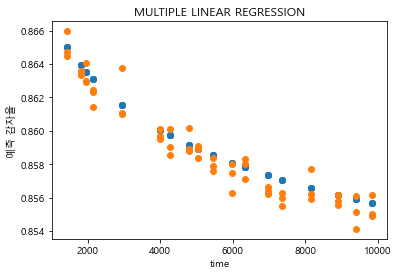

train cv10 R2:[0.35174186 0.65618581 0.665467   0.29436584 0.4861143  0.64494123
 0.59269504 0.79986445 0.93798392 0.81062821]
train cv10 평균점수 : 0.6239987657641743
test set R2:  0.9269797848463495
기울기,절편:  [[-0.00488042]] [0.90053247]


In [28]:
# 3단계)   생성한 데이터로 로그회귀 진행
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

x = up_sampled_data[[X]]
y = up_sampled_data[[Y]]

# 데이터셋 분리
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2, shuffle=False) 

#모델 생성
model = LinearRegression()

x_train_log = np.log(x_train) # x값 ln(x)으로 전환
x_test_log = np.log(x_test)

model.fit(x_train_log, y_train) # model fitting

# K-fold model validation
cv_num =10
arr_score = cross_val_score(model,x_train_log,y_train,scoring='r2',cv=cv_num)


#예측 비교
y_predict = model.predict(x_test_log)
print(len(y_predict))
print(len(y_test))
plt.scatter(x_test, y_predict)#예측 감자율
plt.scatter(x_test, y_test) #실제 감자율
plt.xlabel("time")
plt.ylabel("예측 감자율")
plt.title("MULTIPLE LINEAR REGRESSION")
plt.show()

print(f"train cv{cv_num} R2:{arr_score}")
print(f'train cv{cv_num} 평균점수 : {arr_score.mean()}')
print("test set R2: ", model.score(x_test_log, y_test))
print("기울기,절편: ", model.coef_,model.intercept_)

r_index: 100%|#######################################################################| 14/14 [00:00<00:00, 1399.70it/s]

smogn 변환 전:  (267, 2)
smogn 변환 후:  (207, 2)


<AxesSubplot:xlabel='Time_110', ylabel='Density'>

C:\Users\SIMBA\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\SIMBA\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


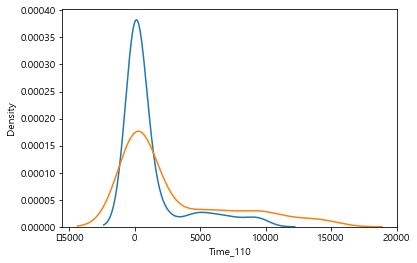

In [29]:
# 4단계)   생성한 데이터에 SMOGN 적용하여 로그회귀 진행
import smogn
import seaborn

data_smogn = smogn.smoter(
    data = up_sampled_data, 
    y = X
)

print("smogn 변환 전: ",up_sampled_data.shape)
print("smogn 변환 후: ",data_smogn.shape)

## plot y distribution 
seaborn.kdeplot(up_sampled_data[X], label = "Original")
seaborn.kdeplot(data_smogn[X], label = "Modified")

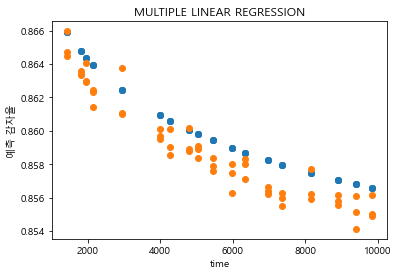

train cv10 R2:[ 0.98922833  0.9913354   0.98311167  0.99125806  0.9917977   0.51896509
  0.81971435  0.84111417  0.90825725 -0.33835536]
train cv10 평균점수 : 0.7696426684083042
test set R2:  0.7687261920840476
기울기,절편:  [[-0.00484601]] [0.90112153]


In [30]:
x_smogn = data_smogn[[X]]
y_smogn = data_smogn[[Y]]

# 데이터셋 분리
x_train, _, y_train, _ = train_test_split(x_smogn, y_smogn, train_size=0.8, test_size=0.2, shuffle=False) 
_, x_test, _, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2, shuffle=False) 

#모델 생성
model = LinearRegression()

x_train_log = np.log(x_train) # x값 ln(x)으로 전환
x_test_log = np.log(x_test)
model.fit(x_train_log, y_train) # model fitting

# K-fold model validation
cv_num =10
arr_score = cross_val_score(model,x_train_log,y_train,scoring='r2',cv=cv_num)


#예측 비교
y_predict = model.predict(x_test_log)
plt.scatter(x_test, y_predict)#예측 감자율
plt.scatter(x_test, y_test) #실제 감자율
plt.xlabel("time")
plt.ylabel("예측 감자율")
plt.title("MULTIPLE LINEAR REGRESSION")
plt.show()

print(f"train cv{cv_num} R2:{arr_score}")
print(f'train cv{cv_num} 평균점수 : {arr_score.mean()}')
print("test set R2: ", model.score(x_test_log, y_test))
print("기울기,절편: ", model.coef_,model.intercept_)